## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

In [6]:
import glob
import csv
from tqdm.auto import tqdm

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()
rows_total = 1363 + 3226
clusters_total = 1300

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amazon.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['name'] = row.pop('title')
            row['source'] = 'google'
            row_dict[row['id']] = row
            left_id_set.add(row['id'])
            pbar.update(1)
    
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/GoogleProducts.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['source'] = 'amazon'
            row_dict[row['id']] = row
            right_id_set.add(row['id'])
            pbar.update(1)

In [7]:
true_pair_set = set()

with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amzon_GoogleProducts_perfectMapping.csv') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

In [8]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_mapping)

2404

In [9]:
len(cluster_dict)

1105

In [10]:
# TODO: deal with this difference
# from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

# assert len(true_pair_set - cluster_dict_to_id_pairs(cluster_dict)) == 0

In [11]:
cluster_attr = 'cluster_id'
max_cluster_id = max(cluster_mapping.values())

for row_id, row in tqdm(row_dict.items()):
    try:
        row[cluster_attr] = cluster_mapping[row_id]
    except KeyError:
        row[cluster_attr] = max_cluster_id
        max_cluster_id += 1

In [12]:
[row_dict[row_id] for row_id in next(iter(true_pair_set))]

[{'id': 938,
  'description': 'improve your typing skills today! typing instructor deluxe has a progressive design that has been developed for over 19 years. typing instructor deluxe can provide the right lessons tests strengthening exercises practice material and typing games for your skill level. you can even build your own personal typing plan to focus on specific areas you would like to improve. if you think learning has to be all hard work and no fun think again! for beginning to advanced typists kids to adults typing instructor deluxe will motivate you to improve your typing speed and accuracy using a travel theme and exciting typing challenges.educates entertains and motivates: choose from many typing plans or build your ownnavigate easily and choose your typing materialnew! dynamic learning methodsave your results and reports to track progresslearn voice-touch typing (dictation)3 unique travel themescolorful photos and musicten exciting games300+ magazine articles',
  'manufact

## Preprocess

In [13]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [14]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = itertools.islice((s_part[:30] for s_part in default_tokenizer(s)), 0, 30)
    return ' '.join(s_tokens)[:300]

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [15]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [16]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [17]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [18]:
from entity_embed import build_row_numericalizer

row_numericalizer = build_row_numericalizer(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

18:07:17 INFO:For attr='name', computing actual alphabet and max_str_len
18:07:17 INFO:For attr='name', using actual_max_str_len=26
18:07:17 INFO:For attr='description', computing actual alphabet and max_str_len
18:07:17 INFO:actual_max_str_len=29 must be pair to enable NN pooling. Updating to 30
18:07:17 INFO:For attr='description', using actual_max_str_len=30
18:07:17 INFO:For attr='manufacturer', computing actual alphabet and max_str_len
18:07:17 INFO:actual_max_str_len=15 must be pair to enable NN pooling. Updating to 16
18:07:17 INFO:For attr='manufacturer', using actual_max_str_len=16
18:07:17 INFO:For attr='price', computing actual alphabet and max_str_len
18:07:17 INFO:For attr='price', using actual_max_str_len=14


{'name': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7f46ff5baca0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None),
 'description': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7f46ff5baca0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', 

In [19]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
datamodule = LinkageDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=50,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    random_seed=random_seed
)

## Training

In [20]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    datamodule,
    ann_k=ann_k,
    use_mask=True,
)

In [21]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'amzn-googl'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

18:07:17 INFO:GPU available: True, used: True
18:07:17 INFO:TPU available: None, using: 0 TPU cores
18:07:17 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
trainer.fit(model, datamodule)

18:07:17 INFO:Train pair count: 292
18:07:17 INFO:Valid pair count: 265
18:07:17 INFO:Test pair count: 998
18:07:19 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 3.3 M 
1 | losser      | SupConLoss | 0     
-------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params


1

In [23]:
model.blocker_net.get_signature_weights()

{'name': 0.27416497468948364,
 'description': 0.2727101147174835,
 'manufacturer': 0.2224285751581192,
 'price': 0.23069636523723602}

## Testing

In [24]:
trainer.test(ckpt_path='best')

18:11:14 INFO:Train pair count: 292
18:11:14 INFO:Valid pair count: 265
18:11:14 INFO:Test pair count: 998



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1_at_0.3': 0.07707910750507099,
 'test_f1_at_0.5': 0.4142604596346494,
 'test_f1_at_0.7': 0.5760102629890955,
 'test_f1_at_0.9': 0.13024282560706402,
 'test_pair_entity_ratio_at_0.3': 13.241222366710012,
 'test_pair_entity_ratio_at_0.5': 1.6644993498049414,
 'test_pair_entity_ratio_at_0.7': 0.47139141742522755,
 'test_pair_entity_ratio_at_0.9': 0.04681404421326398,
 'test_precision_at_0.3': 0.04011784925116622,
 'test_precision_at_0.5': 0.274609375,
 'test_precision_at_0.7': 0.6193103448275862,
 'test_precision_at_0.9': 0.8194444444444444,
 'test_recall_at_0.3': 0.9796163069544365,
 'test_recall_at_0.5': 0.842925659472422,
 'test_recall_at_0.7': 0.5383693045563549,
 'test_recall_at_0.9': 0.07074340527577938}
--------------------------------------------------------------------------------


[{'test_precision_at_0.3': 0.04011784925116622,
  'test_recall_at_0.3': 0.9796163069544365,
  'test_f1_at_0.3': 0.07707910750507099,
  'test_pair_entity_ratio_at_0.3': 13.241222366710012,
  'test_precision_at_0.5': 0.274609375,
  'test_recall_at_0.5': 0.842925659472422,
  'test_f1_at_0.5': 0.4142604596346494,
  'test_pair_entity_ratio_at_0.5': 1.6644993498049414,
  'test_precision_at_0.7': 0.6193103448275862,
  'test_recall_at_0.7': 0.5383693045563549,
  'test_f1_at_0.7': 0.5760102629890955,
  'test_pair_entity_ratio_at_0.7': 0.47139141742522755,
  'test_precision_at_0.9': 0.8194444444444444,
  'test_recall_at_0.9': 0.07074340527577938,
  'test_f1_at_0.9': 0.13024282560706402,
  'test_pair_entity_ratio_at_0.9': 0.04681404421326398}]

## Testing manually 

In [25]:
# Only call this if test above wasn't run
# datamodule.setup(stage='test')

In [26]:
test_row_dict = datamodule.test_row_dict
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    batch_size=16
)

In [27]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [28]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

In [29]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 931 ms, sys: 16.4 ms, total: 947 ms
Wall time: 135 ms


In [30]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)

CPU times: user 1.08 s, sys: 8.17 ms, total: 1.09 s
Wall time: 145 ms


In [31]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

13.241222366710012

In [32]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.04011784925116622, 0.9796163069544365)

In [33]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

19548

In [34]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

17

In [35]:
cos_similarity = lambda a, b: np.dot(a, b)

In [36]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.28523752,
 {'id': 0,
  'description': '',
  'manufacturer': 'broderbund',
  'price': '0',
  'name': 'clickart 950 000 - premier image pack ( dvd - rom )',
  'source': 'google',
  'cluster_id': 0},
 {'id': 3241,
  'name': 'clickart 950000 - premier image pack ( dvd - rom )',
  'description': 'massive collection of images & fonts for all your design needs ondvd - rom ! product informationinspire your creativity and perfect any creative project with thousands ofworld - class images',
  'manufacturer': '',
  'price': '48 . 95',
  'source': 'amazon',
  'cluster_id': 0})

(0.18101764,
 {'id': 799,
  'description': '- marketing information : hp digital sending software 4 . 0 improves core business processes . digital sending streamlines critical business document handling and integrates with existing it infrastructures to',
  'manufacturer': 'hewlett packard ( consumables )',
  'price': '630 . 36',
  'name': 'hp dss software - ( v . 4 . 0 ) - complete package ( t1936aa ua0 )',
  'source': 'google',
  'cluster_id': 799},
 {'id': 3955,
  'name': 'hp t1936aa uao digital sending software 4 . 0 ( 10 device license )',
  'description': 'hp dss 4 . 0 is the entry - level member of a family of server - based software products that enables paper documents to be incorporated into electronic business',
  'manufacturer': 'hp',
  'price': '369 . 99',
  'source': 'amazon',
  'cluster_id': 799})

(0.18483788,
 {'id': 125,
  'description': '',
  'manufacturer': 'compaq computer',
  'price': '0',
  'name': 'compaq comp . rapid deployment pk - flexible lic kit ( 302127 - b21 )',
  'source': 'google',
  'cluster_id': 125},
 {'id': 3231,
  'name': 'hewlett packard 302127 - b21 prol essentials rdp v1 . x 1u flex lic min qty 5',
  'description': 'prol essentials rdp v1 . x 1u flex lic min qty 5',
  'manufacturer': '',
  'price': '119 . 73',
  'source': 'amazon',
  'cluster_id': 125})

(0.1659712,
 {'id': 1138,
  'description': 'flash ad creator creates animated ads that look like a flash developer spent hours creating it . save time & money by creating your own ad in your own time',
  'manufacturer': 'laughing bird',
  'price': '39 . 99',
  'name': 'net ad creator',
  'source': 'google',
  'cluster_id': 1138},
 {'id': 2297,
  'name': 'laughingbird the flash ad creator',
  'description': '',
  'manufacturer': '',
  'price': '34 . 99',
  'source': 'amazon',
  'cluster_id': 1138})

(0.25745112,
 {'id': 199,
  'description': 'upg rumba unix - hp edition level a 1 - 4 units',
  'manufacturer': 'netmanage',
  'price': '0',
  'name': 'netmanage upg rumba unix - hp edition level ( 902453 - 007 - c )',
  'source': 'google',
  'cluster_id': 199},
 {'id': 1428,
  'name': '902453 - 007 - b rumba unix - hp edition - upgrade license - 1 user - volume - level b ( 5 - 49 ) - c',
  'description': 'netmanage 902453 - 007 - b : usually ships in 24 hours : : the rumba product family provides users secure access to mission - critical applications and data residing',
  'manufacturer': '',
  'price': '147 . 73',
  'source': 'amazon',
  'cluster_id': 199})

(0.039942414,
 {'id': 918,
  'description': 'mobi 70008 recam 4 . 6 camera monitoring and notification software surveillance software captures and analyzes images for advanced monitoring and recording of home or office ; program performs simultaneous',
  'manufacturer': 'mobi technologies inc .',
  'price': '129',
  'name': 'recam remote monitoring software',
  'source': 'google',
  'cluster_id': 918},
 {'id': 3921,
  'name': 'mobi - cam 70008 monitoring and notification software',
  'description': 'easily set - up and monitor your home or business observation system from anywhere notification of alarm and viewing via e - mail internet or cell phone multiple camera support',
  'manufacturer': 'mobi - cam',
  'price': '89 . 69',
  'source': 'amazon',
  'cluster_id': 918})

(0.2732501,
 {'id': 795,
  'description': 'arcserve bkup r11 . 5 win client vss software snap - shot - prod only',
  'manufacturer': 'computer associates',
  'price': '0',
  'name': 'ca arcserve bkup r11 . 5 win client vss software snap - shot - prod only',
  'source': 'google',
  'cluster_id': 795},
 {'id': 3957,
  'name': 'computer associates babwbr1151s33 - brightstor arcserve backup client for vss software snap - shot v . 11 . 5 for windows with service pack 1 - add - on -',
  'description': 'computer associates babwbr1151s33 : the brightstor arcserve backup client for vss software snap - shot enables brightstor arcserve backup customers to leverage microsoft windows server 2003 volume shadow copy service',
  'manufacturer': '',
  'price': '799 . 97',
  'source': 'amazon',
  'cluster_id': 795})

(0.11344373,
 {'id': 799,
  'description': '- marketing information : hp digital sending software 4 . 0 improves core business processes . digital sending streamlines critical business document handling and integrates with existing it infrastructures to',
  'manufacturer': 'hewlett packard ( consumables )',
  'price': '630 . 36',
  'name': 'hp dss software - ( v . 4 . 0 ) - complete package ( t1936aa ua0 )',
  'source': 'google',
  'cluster_id': 799},
 {'id': 2167,
  'name': 'hewlett packard t1936aa ua0 - hp digital sending software 4 . 0 - complete product - document management - 1 device ( s ) - complete product - standard -',
  'description': 'hewlett packard t1936aa ua0 : the hp mfp digital sending software ( hp dss ) is a software application that enables an hp multifunction peripheral ( mfp ) to send',
  'manufacturer': '',
  'price': '342 . 97',
  'source': 'amazon',
  'cluster_id': 799})

(-0.100465715,
 {'id': 845,
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99',
  'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  'source': 'google',
  'cluster_id': 845},
 {'id': 2324,
  'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive',
  'manufacturer': '',
  'price': '28 . 99',
  'source': 'amazon',
  'cluster_id': 845})

(0.24289787,
 {'id': 870,
  'description': '- marketing information : tinyterm provides accurate emulation and total flexibility . now you can use your desktop pc to access all your legacy data and applications . with tinyterm',
  'manufacturer': 'century software',
  'price': '219 . 63',
  'name': 'tiny term emulator v4 . 3x',
  'source': 'google',
  'cluster_id': 870},
 {'id': 3851,
  'name': 'century software tt - 1 - century tinyterm v . 4 . 3x - emulation - 1 user ( s ) - english french german spanish italian polish portuguese -',
  'description': 'century software tt - 1 : tinyterm provides accurate emulation and total flexibility . now you can use your desktop pc to access all your legacy data and applications .',
  'manufacturer': '',
  'price': '120 . 97',
  'source': 'amazon',
  'cluster_id': 870})

## t-sne visualization

In [37]:
vis_sample_size = 10

In [38]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [39]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [40]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

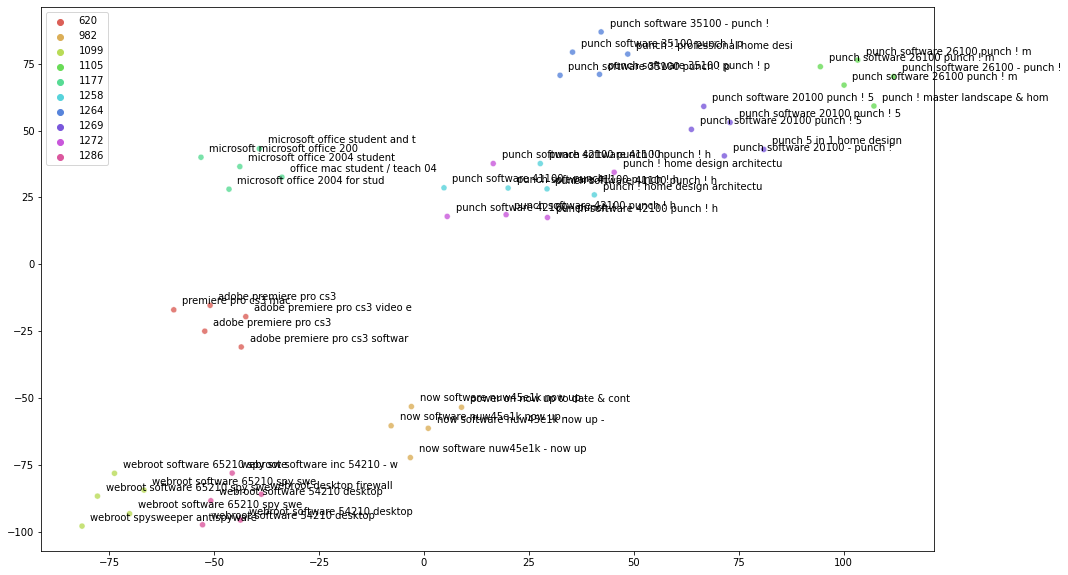

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)